## Social Media Mining to Analyze Discussion of Long COVID and Diabetes, File 1

### by Sayan Swar ad Aparna Palit, 12/11/2022

#### This script analyzes the tweets related to Long Covid

#### Code to download all required libraries/packages

In [ ]:
#!pip install pyngrok -q
# from pyngrok import ngrok
# print(ngrok.connect(8888))

In [ ]:
#SNS Scrape Module Install
#! pip install snscrape
#! pip install git+https://github.com/JustAnotherArchivist/snscrape.git

In [ ]:
#GSDMM Module Install
#! pip install git+https://github.com/rwalk/gsdmm.git

In [ ]:
#FastText Language IDentification Install
# !pip install fasttext
# !wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz

In [ ]:
#!pip install pyLDAvis==3.3.0

#### Importing all necessary libraries

In [99]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import numpy as np
import gensim
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import re
import copy
import seaborn as sns
from collections import Counter
from operator import itemgetter

import fasttext

import pickle
import gsdmm
from gsdmm import MovieGroupProcess
from tqdm import tqdm


#setiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
vader = SentimentIntensityAnalyzer()

import warnings
warnings.filterwarnings("ignore")

#### Cleaning of Data, removing special characters, hyperlinks etc.

In [100]:
# #getting tweets where both diabetes and covid has been mentioned
# maxTweets = 100000
# tweets_list_longcovid = []
# for i,tweet in enumerate(sntwitter.TwitterSearchScraper('"Long Covid" OR #LongCovid since:2022-01-01 until:2022-10-24').get_items()):
#     if i>maxTweets:
#         break
#     tweets_list_longcovid.append([tweet.date, tweet.id, tweet.content, tweet.username, tweet.likeCount, tweet.sourceLabel, \
#                          tweet.retweetCount, tweet.user.favouritesCount, tweet.user.location, tweet.url])

# tweets_df_longcovid = pd.DataFrame(tweets_list_longcovid, columns=['Datetime', 'TweetId', 'Text', 'Username',\
#                                             'LikeCount','SourceLabel','RetweetCount','FavouriteCount',\
#                                             'UserLocation', 'Url'])
# tweets_df_longcovid['ClassLabel'] = 0

# tweets_df_longcovid.to_csv("Large_LongCovid19_Effect_11272022.csv", index = False)

tweets_df_longcovid = pd.read_csv("Large_LongCovid19_Effect_11272022.csv",lineterminator='\n')


In [101]:
# #In this step we separately look into diabetes and covid
# maxTweets = 100000
# tweets_list_long_covid_diab = []

# for i,tweet in enumerate(sntwitter.TwitterSearchScraper('(LongCovid AND Diabetes) OR ("long covid" and diabetes) OR (long covid diabetes) since:2022-01-01 until:2022-10-24').get_items()):
#     if i>maxTweets:
#         break
#     tweets_list_long_covid_diab.append([tweet.date, tweet.id, tweet.content, tweet.username, tweet.likeCount, tweet.sourceLabel, \
#                          tweet.retweetCount, tweet.user.favouritesCount, tweet.user.location, tweet.url])

# tweets_df_long_covid_diab = pd.DataFrame(tweets_list_long_covid_diab, columns=['Datetime', 'TweetId', 'Text', 'Username',\
#                                                 'LikeCount','SourceLabel','RetweetCount','FavouriteCount',\
#                                                 'UserLocation', 'Url'])

# tweets_df_long_covid_diab['ClassLabel'] = 1

# tweets_df_long_covid_diab.to_csv("Large_LongCovid19_Diabetes_Effect_11282022.csv", index = False)

tweets_df_long_covid_diab = pd.read_csv("Long_Covid19_Diabetes_Effect_11272022.csv",lineterminator='\n')


In [147]:
#number of tweets coming when tweets contain all the keywords such as long covid and diabetes
tweets_df_long_covid_diab.Datetime = pd.to_datetime(tweets_df_long_covid_diab.Datetime)

# tweets_df_long_covid_diab\
# .groupby(tweets_df_long_covid_diab.Datetime.dt.date)['TweetId'].count().plot(kind='line', color='g', figsize=(16,5))
# plt.xlabel('Year')
# plt.ylabel('Daily Tweets')
# plt.show()
# print(len(tweets_df_long_covid_diab))

In [103]:
tweets_df_merge_stg1 = \
pd.concat([tweets_df_longcovid,tweets_df_long_covid_diab], ignore_index=True).\
drop_duplicates(subset='TweetId', keep='first', ignore_index=True)

In [148]:
tweets_df_merge = copy.deepcopy(tweets_df_merge_stg1)

#### Cleaning of Data, removing special characters, hyperlinks etc.

In [151]:
#code to find all the texts with Hashtags
def extacthashtags(row):
    pattern = r'#\S+'
    l = list()
    x = re.findall(pattern, row.Text)
    if len(x)!=0:
        for i in x:
            z = re.sub("[^a-zA-Z0-9#]", "",i)
            if z.lower()=='#covid19':
                z='#covid'
            l.append(z.lower())
            
    return (l if len(x)!=0 else 'NA')

tweets_df_merge["Hastags"] = tweets_df_merge.apply(extacthashtags,axis='columns')

In [152]:
#code to remove @user data, special characters,words such as ohh, hmm single charecters and words lesser than len 3 
#we might need to change the len 3 constraint and change to 2. We will check that as we move forward.

#remove users
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)      
    return input_txt   

#remove links from tweets
def remove_links(tweet):
    """Takes a string and removes web links from it"""
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    return tweet

def remove_hashtags(tweet):
    """Takes a string and removes any hash tags"""
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
    return tweet

def remove_doublespace(tweet):
    """Takes a string and removes any double space"""
    tweet = re.sub('\s+', ' ', tweet)
    return tweet

def replace_type_keywords(row):
    if row.lower().find('type 1') != -1:
        return row.lower().replace('type 1', 'typeone ')
    elif row.lower().find('type 2') != -1:
        return row.lower().replace('type 2', 'typetwo ')
    elif row.lower().find('type i') != -1:
        return row.lower().replace('type i', 'typeone ')
    elif row.lower().find('type ii') != -1:
        return row.lower().replace('type ii', 'typetwo ')
    else:
        return row

def remove_amp(row):
    if row.find('&amp') != -1:
        return row.replace('&amp', ' ')
    else:
        return row

def remove_singlequote(row):
    if (row.find('\'') != -1 or row.find('’') != -1):
        r = row.replace('\'', '')
        r = r.replace('’','')
        return r
    else:
        return row
    
    
tweets_df_merge['Clean_Text'] = np.vectorize(remove_doublespace)(tweets_df_merge.Text)
tweets_df_merge['Clean_Text'] = np.vectorize(remove_pattern)(tweets_df_merge.Clean_Text, "@[\w]*")
tweets_df_merge['Clean_Text'] = np.vectorize(remove_links)(tweets_df_merge.Clean_Text)

tweets_df_merge['Clean_Text'] = np.vectorize(replace_type_keywords)(tweets_df_merge.Clean_Text)
tweets_df_merge['Clean_Text'] = np.vectorize(remove_amp)(tweets_df_merge.Clean_Text)
tweets_df_merge['Clean_Text'] = np.vectorize(remove_singlequote)(tweets_df_merge.Clean_Text)
tweets_df_merge['Clean_Text'] = tweets_df_merge['Clean_Text'].str.lower()

# tweets_df_merge['Clean_Text'] = np.vectorize(remove_hashtags)(tweets_df_merge.Clean_Text) --not removing hastags yet, as many sentence have meaning with hastag, e.g. 5
tweets_df_merge['Clean_Text'] = tweets_df_merge['Clean_Text'].str.replace("[^a-zA-Z#]", " ") #removing special chars, numbers, unctualtions
tweets_df_merge['Clean_Text'] = np.vectorize(remove_doublespace)(tweets_df_merge.Clean_Text)


#### Cleaning of Data, tokenization and lemmatization

In [153]:
#Stemming and Tokenization  
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None
    
def tokenize(tweet):
    result = []
    for token in gensim.utils.simple_preprocess(tweet):
        if token not in gensim.parsing.preprocessing.STOPWORDS \
                and len(token) > 2:  # drops words with less than 3 characters
            #token = nltk.PorterStemmer().stem(token) #adding this line to stem words such as vaccinate to vaccine. Cant use it.
            result.append(lemmatize(token))
    return result

def lemmatize(token):
    lemma = WordNetLemmatizer()
    pos_tagged = nltk.pos_tag([token]) 
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    for word, tag in wordnet_tagged:
        if tag is None:
            return word
        else:       
             return lemma.lemmatize(word, tag)
            #return WordNetLemmatizer().lemmatize(token, pos='v')

def preprocess_tweet(tweet):
    tweet = tweet.lower()                # lower case
    tweet = re.sub('\s+', ' ', tweet)    # remove double spacing
    tweet_token_list = tokenize(tweet)   
    tweet = ' '.join(tweet_token_list)
    return tweet

tweets_df_merge['Clean_Text_TokenStem'] = np.vectorize(preprocess_tweet)(tweets_df_merge.Clean_Text)



#### Filtering data and keeping only english Language Tweets

In [159]:
#Identifying Tweet Language, so that we can keep only english tweets.
fmodel = fasttext.load_model('lid.176.ftz')
tweets_df_merge['language'] = tweets_df_merge['Clean_Text_TokenStem'].apply(lambda x: fmodel.predict([x])[0][0][0].split('__label__')[1]) # detect tweet language

tweets_df_merge = tweets_df_merge[tweets_df_merge['language']=='en']
tweets_df_merge = tweets_df_merge.reset_index(drop=True)


In [160]:
#identifying all the tweets where Diabetes has been discussed:
def identify_tweets_with_diabetes(tweet):
    if (tweet.lower().find('diabetes') != -1):
        return 'Long Covid Diabetes'
    else:
        return 'Long Covid'

tweets_df_merge["Long_Covid_Diabetes_ClassLabel"] = \
                                    np.vectorize(identify_tweets_with_diabetes)(tweets_df_merge.Clean_Text)

In [161]:
tweets_df_merge['Datetime'] = pd.to_datetime(tweets_df_merge['Datetime'])
#Keeping Tweets of multiple scrapes from within a particular date range. 
tweets_df_merge['TweetDate'] = tweets_df_merge.Datetime.dt.date
mindate_0 = tweets_df_merge[tweets_df_merge.ClassLabel==0].TweetDate.min()
tweets_df_merge = tweets_df_merge[tweets_df_merge.TweetDate>=mindate_0].reset_index(drop=True)
print(mindate_0)
print(tweets_df_merge[tweets_df_merge.ClassLabel==0].TweetDate.max())

2022-10-06
2022-10-23


In [157]:
#Text Analysis Code
print(tweets_df_merge.Text[7547])
print(' ')
print(tweets_df_merge.Clean_Text[7547])
print(' ')
print(tweets_df_merge.Clean_Text_TokenStem[7547])
print(' ')
print(tweets_df_merge.Url[7547])

Coming off the successful #MillionsMissing protests in DC, Edinburgh, and London, I have a big task ahead of me. We need to continue this momentum that these protests started. We have to keep ME in the news and in the conversation with Long COVID.
 
coming off the successful #millionsmissing protests in dc edinburgh and london i have a big task ahead of me we need to continue this momentum that these protests started we have to keep me in the news and in the conversation with long covid 
 
come successful millionsmissing protest edinburgh london big task ahead need continue momentum protest start news conversation long covid
 
https://twitter.com/MEActNet/status/1583508335651090432


#### Working on EDA to find important trends in Data

In [162]:
tweets_df_merge=tweets_df_merge[tweets_df_merge.Clean_Text_TokenStem.str.split().str.len()>=5].reset_index(drop=True)

Long Covid             64015
Long Covid Diabetes      241
Name: Long_Covid_Diabetes_ClassLabel, dtype: int64


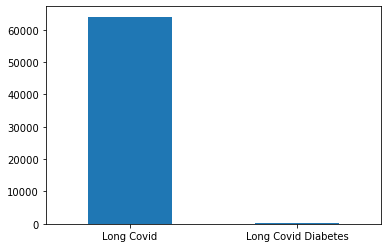

In [163]:
print(tweets_df_merge.Long_Covid_Diabetes_ClassLabel.value_counts())

tweets_df_merge['Long_Covid_Diabetes_ClassLabel'].value_counts().plot(kind = 'bar')
plt.xticks(rotation=0)
plt.show()

In [164]:
tweets_df_merge_descriptive = tweets_df_merge[['TweetId','Datetime','Text','Clean_Text_TokenStem',\
                                                         'LikeCount','SourceLabel','RetweetCount','FavouriteCount',\
                                                         'ClassLabel','Hastags','Long_Covid_Diabetes_ClassLabel']]

In [165]:
tweets_df_merge_descriptive['TweetDate'] = tweets_df_merge.Datetime.dt.date
tweets_df_merge_descriptive['TweetYear'] = tweets_df_merge.Datetime.dt.year.astype('int')
tweets_df_merge_descriptive['TweetlenRaw'] = tweets_df_merge.Text.str.split().str.len()
tweets_df_merge_descriptive['TweetlenClean'] = tweets_df_merge.Clean_Text_TokenStem.str.split().str.len()

#hashtag count
hashtags = tweets_df_merge.Hastags
coditions = [(hashtags=='NA'),(hashtags!='NA')]
values = [0,hashtags.apply(len)]
tweets_df_merge_descriptive['HashTagCount'] = np.select(coditions,values)

#description of few numerical columns
tweets_df_merge_descriptive[['LikeCount','RetweetCount','FavouriteCount',\
                             'TweetlenRaw','TweetlenClean','HashTagCount']].describe()

,LikeCount,RetweetCount,FavouriteCount,TweetlenRaw,TweetlenClean,HashTagCount
count,64256.000000,64256.000000,6.425600e+04,64256.000000,64256.000000,64256.000000
mean,16.723730,3.635131,4.567612e+04,32.321044,15.154631,0.705771
std,169.961823,45.874437,8.140809e+04,13.877552,6.342716,1.761109
min,0.000000,0.000000,0.000000e+00,2.000000,5.000000,0.000000
25%,0.000000,0.000000,3.306000e+03,20.000000,10.000000,0.000000
50%,1.000000,0.000000,1.539900e+04,33.000000,15.000000,0.000000
75%,4.000000,0.000000,5.258775e+04,44.000000,20.000000,1.000000
max,13153.000000,3723.000000,1.347919e+06,105.000000,37.000000,28.000000


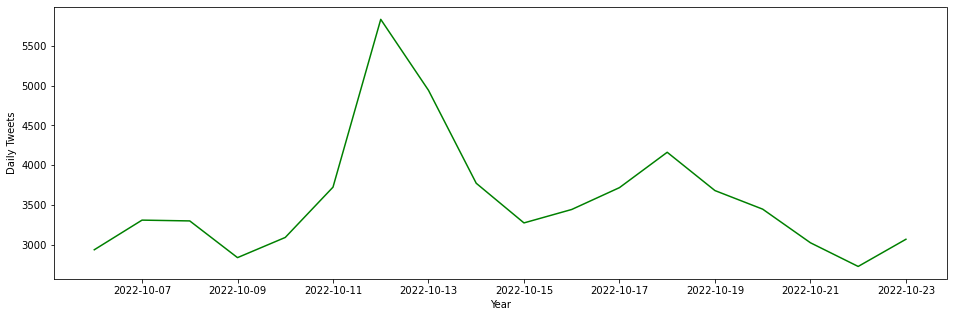

In [166]:
#plot the data for number of daily tweet counts
tweets_df_merge_descriptive\
.groupby('TweetDate')['TweetId'].count().plot(kind='line', color='g', figsize=(16,5))
plt.xlabel('Year')
plt.ylabel('Daily Tweets')
plt.show()

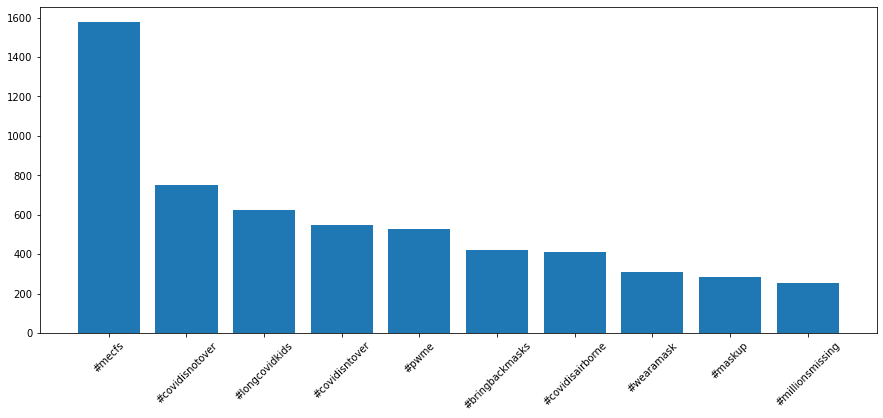

In [167]:
#Top 10 Hastags
seq = tweets_df_merge.Hastags
AllHashtagCounts = dict(Counter(x for xs in seq for x in set(xs)))
del AllHashtagCounts['N']
del AllHashtagCounts['A']
del AllHashtagCounts['#longcovid']
del AllHashtagCounts['#covid']

AllHashtagCounts_Nlarge = dict(sorted(AllHashtagCounts.items(), key = itemgetter(1), reverse = True)[:10])

names = list(AllHashtagCounts_Nlarge.keys())
values = list(AllHashtagCounts_Nlarge.values())

plt.figure(figsize=(15, 6))
plt.bar(range(len(AllHashtagCounts_Nlarge)), values, tick_label=names)
plt.xticks(rotation = 45)
plt.show()

In [168]:
#Change from Baseline Statistics of daily tweet counts for both covid diabetes
baseline_track_covdiabet_tweets = \
tweets_df_merge_descriptive[tweets_df_merge_descriptive.ClassLabel==0].TweetDate.value_counts()
baseline_track_covdiabet_tweets = baseline_track_covdiabet_tweets.sort_index().to_frame()
baseline_track_covdiabet_tweets['Change'] = \
baseline_track_covdiabet_tweets.apply(lambda x: x - x.iloc[0])

print(baseline_track_covdiabet_tweets.Change.describe())

count      18.000000
mean      642.166667
std       773.558945
min      -203.000000
25%       144.750000
50%       446.500000
75%       793.500000
max      2907.000000
Name: Change, dtype: float64


In [169]:
#Calculating Similarity between Clean Text Toekenized and Clean Text to make sure we are not deviating
similarity_check_between_rawclean_tweets = \
tweets_df_merge[['TweetId','Datetime','Clean_Text','Clean_Text_TokenStem']]

def findsimilarity(row):
    doc1_list = row.Clean_Text.lower().split(" ")
    doc2_list = row.Clean_Text_TokenStem.lower().split(" ")
    set_1 = set(doc1_list)
    set_2 = set(doc2_list)
    n = len(set_1.intersection(set_2))
    sim = n / float(len(set_1.union(set_2)))
    return sim

similarity_check_between_rawclean_tweets["SimilarityIdx"] = \
similarity_check_between_rawclean_tweets.apply(findsimilarity,axis='columns')

similarity_check_between_rawclean_tweets.SimilarityIdx.describe()

count    64256.000000
mean         0.338497
std          0.109652
min          0.000000
25%          0.269231
50%          0.333333
75%          0.400000
max          0.941176
Name: SimilarityIdx, dtype: float64

### Beginning Topic Modelling From Here 
#### Short Text Topic Modelling GSDMM Test

In [170]:
#Topic Modelling Begins
#creating Token
tweets_df_merge['tokens'] = tweets_df_merge.Clean_Text_TokenStem.apply(lambda x:  
                                             re.split('\s', x))

docs = tweets_df_merge['tokens'].tolist()

In [171]:
docs = [[ele for ele in sub if ele != 'covid'] for sub in docs]
docs = [[ele for ele in sub if ele != 'long'] for sub in docs]
docs = [[ele for ele in sub if ele != 'longcovid'] for sub in docs]

In [172]:
#Hyperparameters configured, working on trainning the model

# train STMM model
mgp_output = MovieGroupProcess(K=6, alpha=0.1, beta=0.1, n_iters=30)
allwords = set(x for doc in docs for x in doc)
n_terms = len(allwords)
y = mgp_output.fit(docs, n_terms)

# save model
with open('STMM_Topics_LongCov.model', 'wb') as f:
    pickle.dump(mgp_output, f)
    f.close()

In stage 0: transferred 49614 clusters with 6 clusters populated
In stage 1: transferred 37270 clusters with 6 clusters populated
In stage 2: transferred 25906 clusters with 6 clusters populated
In stage 3: transferred 17357 clusters with 6 clusters populated
In stage 4: transferred 13924 clusters with 6 clusters populated
In stage 5: transferred 12431 clusters with 6 clusters populated
In stage 6: transferred 11308 clusters with 6 clusters populated
In stage 7: transferred 10923 clusters with 6 clusters populated
In stage 8: transferred 10682 clusters with 6 clusters populated
In stage 9: transferred 10256 clusters with 6 clusters populated
In stage 10: transferred 10054 clusters with 6 clusters populated
In stage 11: transferred 9912 clusters with 6 clusters populated
In stage 12: transferred 9849 clusters with 6 clusters populated
In stage 13: transferred 9873 clusters with 6 clusters populated
In stage 14: transferred 9810 clusters with 6 clusters populated
In stage 15: transferred

In [173]:
#Helper Functions to analyze the topics that has been uncovered by STMM Model

# helper functions
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts =sorted(mgp_output.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print('Cluster %s : %s'%(cluster,sort_dicts))
        print(' — — — — — — — — —')

def get_topic_name(doc, topic_dict):
    topic_desc = topic_dict[doc]
    return topic_desc

In [174]:
#Information After Topic Modelling
doc_count = np.array(mgp_output.cluster_doc_count)
print('Number of documents per topic :', doc_count)
print('*'*20)

# topics sorted by the number of documents they are allocated to
top_index = doc_count.argsort()[-10:][::-1]
print('Most important clusters (by number of docs inside):',   
       top_index)
print('*'*20)

# show the top 10 words in term frequency for each cluster 
topic_indices = np.arange(start=0, stop=len(doc_count), step=1)
top_words(mgp.cluster_word_distribution, topic_indices, 10)

Number of documents per topic : [14156  5593  9790 15426  4764 14527]
********************
Most important clusters (by number of docs inside): [3 5 0 2 1 4]
********************
Cluster 0 : [('get', 2471), ('like', 2030), ('symptom', 1758), ('day', 1706), ('year', 1662), ('people', 1564), ('dont', 1549), ('feel', 1525), ('know', 1498), ('time', 1495)]
 — — — — — — — — —
Cluster 1 : [('symptom', 848), ('people', 677), ('patient', 675), ('post', 626), ('cf', 539), ('mecfs', 536), ('blood', 530), ('research', 520), ('study', 517), ('disease', 488)]
 — — — — — — — — —
Cluster 2 : [('people', 1343), ('patient', 1209), ('need', 1141), ('research', 1050), ('help', 997), ('support', 850), ('mecfs', 838), ('health', 798), ('treatment', 687), ('work', 686)]
 — — — — — — — — —
Cluster 3 : [('people', 4310), ('vaccine', 4004), ('know', 2881), ('get', 2192), ('dont', 2073), ('risk', 2013), ('infection', 1912), ('death', 1449), ('symptom', 1386), ('vaccinate', 1219)]
 — — — — — — — — —
Cluster 4 : [

#### LDA Topic Modelling using SKLearn

In [179]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

stopwords.add('longcovid')
stopwords.add('ive')

count_para_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5,\
                            max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(tweets_df_merge.Clean_Text_TokenStem) 

from sklearn.decomposition import LatentDirichletAllocation

lda_para_model = LatentDirichletAllocation(n_components = 6, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

In [180]:
def display_topics(model, features, no_top_words=10):
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1]
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print(" %s (%2.2f)" % (features[largest[i]], word_vector[largest[i]]*100.0/total))


display_topics(lda_para_model, count_para_vectorizer.get_feature_names())


Topic 00
 symptom (2.13)
 damage (1.47)
 cause (1.43)
 brain (1.33)
 heart (1.13)
 like (1.11)
 issue (0.99)
 know (0.97)
 thing (0.88)
 post (0.82)

Topic 01
 people (6.09)
 know (2.28)
 vaccine (1.70)
 million (1.69)
 dont (1.55)
 die (1.53)
 suffer (1.10)
 vaccinate (0.99)
 death (0.95)
 study (0.79)

Topic 02
 health (2.00)
 people (1.42)
 research (1.32)
 patient (1.18)
 study (1.03)
 new (0.86)
 care (0.79)
 infection (0.73)
 need (0.71)
 work (0.67)

Topic 03
 like (1.52)
 work (1.27)
 day (1.18)
 year (1.13)
 dont (1.06)
 feel (1.04)
 time (0.96)
 think (0.90)
 know (0.76)
 people (0.72)

Topic 04
 mask (2.83)
 mecfs (1.29)
 need (1.29)
 wear (1.21)
 help (1.12)
 child (1.10)
 dont (1.05)
 doctor (0.96)
 kid (0.93)
 patient (0.93)

Topic 05
 vaccine (2.62)
 risk (2.62)
 infection (2.51)
 month (1.86)
 study (1.41)
 symptom (1.35)
 reduce (1.08)
 booster (1.07)
 year (0.96)
 chance (0.90)


In [181]:
import pyLDAvis.sklearn
lda_display = pyLDAvis.sklearn.prepare(lda_para_model, count_para_vectors,count_para_vectorizer, sort_topics=False)
pyLDAvis.display(lda_display)

/Users/sayankrswar/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/sayankrswar/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/sayankrswar/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/sayankrswar/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/sayankrswar/opt/anaconda3/lib/python3.9/site-

### Word Cloud Visualization

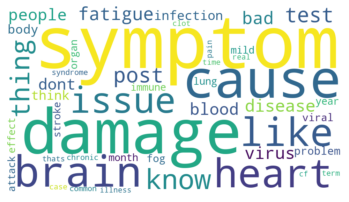

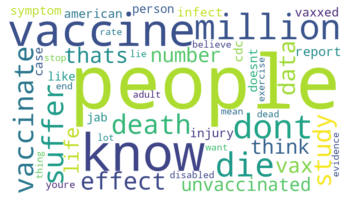

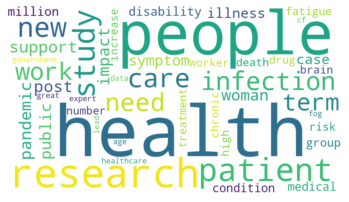

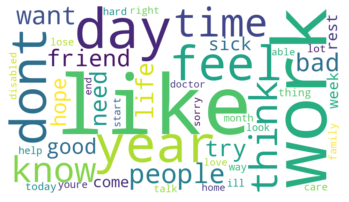

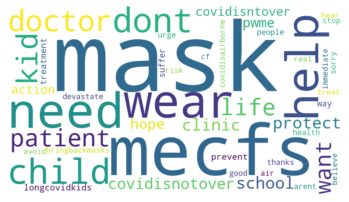

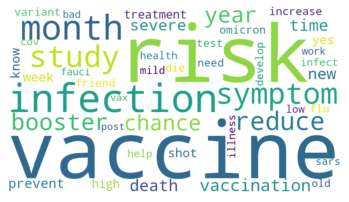

In [182]:
from wordcloud import WordCloud

def wordcloud_topics(model, features, no_top_words=45): 
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order 
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100,width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(6,6))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")

wordcloud_topics(lda_para_model, count_para_vectorizer.get_feature_names())